In [1]:
import imageio.v3 as iio
import matplotlib.pyplot as plt

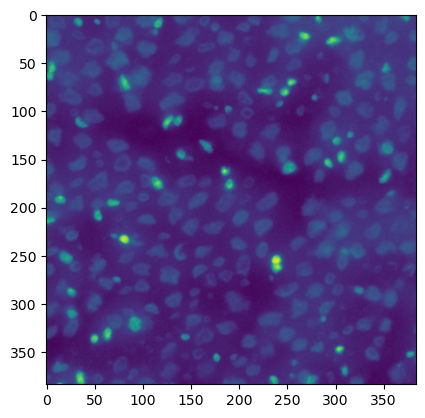

In [2]:
img = iio.imread(r"S:\Phys\FIV925 XSection\Datasets\Brain\ToVizCom\tile_21120_13056.png")
plt.imshow(img)